In [1]:
import time
import os
import copy
import pandas as pd
import numpy as np
import sklearn.metrics as metrics
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import random_split
import torchvision
from torchvision.io import read_image
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

class SatellitesDetectorDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir 
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform: 
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet152(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    val_loss_history = []
    train_loss_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float("inf")

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'train':
                train_loss_history.append(epoch_loss)
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, val_loss_history, train_loss_history, range(num_epochs)

def TestModel(model, dataloaders):
    prec = []
    acc = []
    rec = []
    f1 = []
    prec_s = 0
    rec_s = 0
    f1_s = 0

    all_targets = np.array([])
    all_predictions = np.array([])

    for batch_idx, (data,targets) in enumerate(dataloaders['test']):
        data = data.to(device="cuda")
        targets = targets.to(device="cuda")
        ## Forward Pass
        scores = model(data)
        _, predictions = scores.max(1)
        targets = targets.cpu()
        predictions = predictions.cpu()
        all_targets = np.concatenate((all_targets, targets.numpy()), axis=None)
        all_predictions = np.concatenate((all_predictions, predictions.numpy()), axis=None)

    prec = (metrics.precision_score(all_targets, all_predictions, average=None))
    acc = (metrics.accuracy_score(all_targets, all_predictions))
    rec = (metrics.recall_score(all_targets, all_predictions, average=None))
    f1 = (metrics.f1_score(all_targets, all_predictions, average=None))
    prec_s = metrics.precision_score(all_targets, all_predictions, average='macro')
    rec_s = metrics.recall_score(all_targets, all_predictions, average='macro')
    f1_s = metrics.f1_score(all_targets, all_predictions, average='macro')

    print("Macro metrics:");
    print(f"Precision = {prec_s}")
    print(f"Recall = {rec_s}")
    print(f"F1 = {f1_s}")
    print(f"Accuracy = {acc}")
    print("\nMetrics Details:")
    print(f"Precision = {prec}")
    print(f"Recall = {rec}")
    print(f"F1 = {f1}")

In [2]:
# Initialize the model for this run
feature_ext=True
model_ft, input_size = initialize_model("resnet", 10, feature_extract=feature_ext, use_pretrained=True)

# TRY Send the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_ext:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=0.001)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Transform settings
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Lambda(lambda image: image.convert('RGB')),
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Lambda(lambda image: image.convert('RGB')),
        transforms.Resize(input_size), 
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Lambda(lambda image: image.convert('RGB')),
        transforms.Resize(input_size), 
        transforms.ToTensor(), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#preparing the train, validation and test dataset
torch.manual_seed(43)
train_ds = SatellitesDetectorDataset(annotations_file='D:/Documents/CNN/Satellite Detector/SatellitesDataset/sd_labels.csv',
                                     img_dir='D:/Documents/CNN/Satellite Detector/SatellitesDataset/satellites_data_bn/', 
                                     transform=data_transforms['train'])
val_size = 100
test_size = 100
train_size = len(train_ds) - val_size - test_size
train_ds, val_ds, test_ds = random_split(train_ds, [train_size, val_size, test_size])
val_ds.transform = data_transforms['val']
test_ds.transform = data_transforms['test']

# Create training and validation datasets
#image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
image_datasets = {'train':train_ds, 'val':val_ds, 'test':test_ds}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True) for x in ['train', 'val', 'test']}

cuda
Params to learn:
	 fc.weight
	 fc.bias


In [3]:
# Train and evaluate
model_ft, val_acc_hist, val_loss_hist, train_loss_hist, xplot = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=70, is_inception=False)

Epoch 0/69
----------
train Loss: 0.9234 Acc: 0.7287
val Loss: 0.5416 Acc: 0.8600

Epoch 1/69
----------
train Loss: 0.5635 Acc: 0.8285
val Loss: 0.5283 Acc: 0.8300

Epoch 2/69
----------
train Loss: 0.5241 Acc: 0.8378
val Loss: 0.6019 Acc: 0.8100

Epoch 3/69
----------
train Loss: 0.4816 Acc: 0.8463
val Loss: 0.3110 Acc: 0.8900

Epoch 4/69
----------
train Loss: 0.4752 Acc: 0.8492
val Loss: 0.3736 Acc: 0.8500

Epoch 5/69
----------
train Loss: 0.4577 Acc: 0.8585
val Loss: 0.5185 Acc: 0.8600

Epoch 6/69
----------
train Loss: 0.4466 Acc: 0.8595
val Loss: 0.3793 Acc: 0.8500

Epoch 7/69
----------
train Loss: 0.4441 Acc: 0.8599
val Loss: 0.2098 Acc: 0.9400

Epoch 8/69
----------
train Loss: 0.4308 Acc: 0.8633
val Loss: 0.6830 Acc: 0.8300

Epoch 9/69
----------
train Loss: 0.4386 Acc: 0.8624
val Loss: 0.2699 Acc: 0.9000

Epoch 10/69
----------
train Loss: 0.3961 Acc: 0.8707
val Loss: 0.3829 Acc: 0.8800

Epoch 11/69
----------
train Loss: 0.4134 Acc: 0.8726
val Loss: 0.3305 Acc: 0.9000

Ep

In [4]:
# SAVING THE MODEL
torch.save(model_ft, "sd_resnet152-10cls-bnimg.pth") #SAVES THE TRAINED MODEL

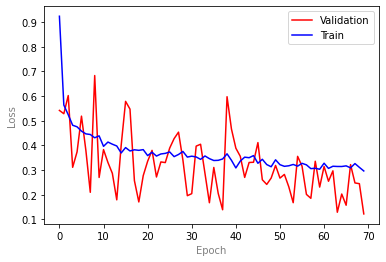

In [5]:
plt.xlabel('Epoch', color='gray')
plt.ylabel('Loss', color='gray')
plt.plot(xplot, val_loss_hist, 'r', xplot, train_loss_hist, 'b')
plt.legend(['Validation', 'Train'], loc=1)
plt.show()

In [ ]:
# USING IT FOR THE TEST SET
model_ft = torch.load("sd_resnet18-10cls-bnimg.pth") 
model_ft.eval()

In [ ]:
TestModel(model_ft,dataloaders_dict)